# Master Equation Solver: Dynamics of a Spin Chain

Authors: J.R. Johansson and P.D. Nation

Modifications: C. Staufenbiel (2022)

### Introduction

In this tutorial we will simulate a spin chain (also called the Heisenberg model), which consists of $N$ $\frac{1}{2}-$spins/qubits in a magnetic field. Each spin can interact with its direct neighbors. This model is often used for the study of magnetic systems.

The one dimensional Heisenberg model, which we consider here, can be solved exactly using the Bethe Ansatz (i.e. we can calculate the spectrum of the Hamiltonian).
### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,
                   tensor)

%matplotlib inline

### Setup System
The Hamiltonian of the spin-chain consists of the interaction part between the spins and the magnetic field. We assume that the magnetic field acts along the $z$-axis of the spin and its strength is defined by $h_n$ for the $n$-th spin. Hence the field strength can vary per spin. 

The spins interact in each direction. Therefore we define the three coefficients $J_x^{(n)}, J_y^{(n)}, J_z^{(n)}$, where the $n$-th coefficient defines the interaction between the spin $n$ and spin $(n+1)$. The Hamiltonian of the Heisenberg model can then be written as:

$\displaystyle H = - \frac{1}{2}\sum_n^N h_n \sigma_z(n) - \frac{1}{2} \sum_n^{N-1} [ J_x^{(n)} \sigma_x(n) \sigma_x(n+1) + J_y^{(n)} \sigma_y(n) \sigma_y(n+1) +J_z^{(n)} \sigma_z(n) \sigma_z(n+1)]$

Below we define the size, initial state and the interaction coefficients for the system. We choose an initial state where the first spin is in the *up* state, while all others are in the *down* state. Furthermore, we select a uniform magnetic field and set $J_x = J_y = J_z$. You can modify these settings to simulate a different spin chain.

In [2]:
# Set the system parameters
N = 5

# initial state
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)

# Energy splitting term
h = 2 * np.pi * np.ones(N)

# Interaction coefficients
Jx = 0.2 * np.pi * np.ones(N)
Jy = 0.2 * np.pi * np.ones(N)
Jz = 0.2 * np.pi * np.ones(N)

For each qubit we setup an operator $\sigma_i$, which is the tensor product of identities and $\sigma_i$ at the position of the qubit. We can then generate the Hamiltonian using these tensor product operators and the coefficients defined above. 

In [3]:
# Setup operators for individual qubits
sx_list, sy_list, sz_list = [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
H = 0
for i in range(N):
    H -= 0.5 * h[i] * sz_list[i]

# Interaction terms
for n in range(N - 1):
    H += -0.5 * Jx[n] * sx_list[n] * sx_list[n + 1]
    H += -0.5 * Jy[n] * sy_list[n] * sy_list[n + 1]
    H += -0.5 * Jz[n] * sz_list[n] * sz_list[n + 1]

### Time evolution
We can simulate the system using the `qutip.mesolve` function. Here, we don't pass any collapse or expectation operators. This results in the function returning the states at each given time step. We convert these states into the density matrices for simple usage in the following.

In [4]:
times = np.linspace(0, 100, 200)
result = mesolve(H, psi0, times, [], [])
# Convert states to density matrices
states = [s * s.dag() for s in result.states]

To visualize the dynamics of the spin chain we calculate the expectation value of $\sigma_z$ for each qubit. For a better overview we only plot the expectation value for the first and the last qubit. We can see that the first spin starts with expecation value $-1$ while the last starts with expecation value $+1$, which is due to the intial state. Over time we can observe the constant transfer of spin momentum between the spins.

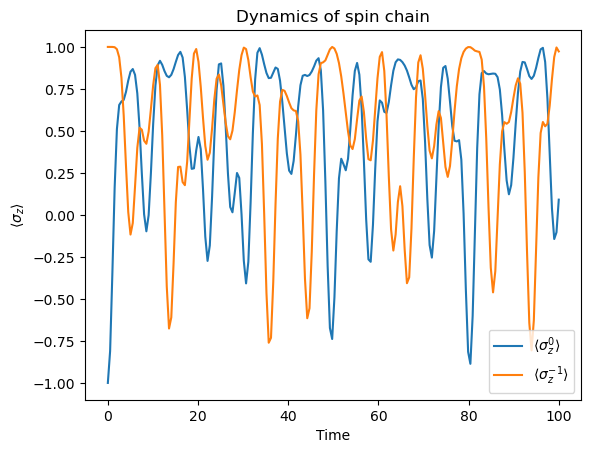

In [5]:
# Expectation value
exp_sz = np.array(expect(states, sz_list))

# Plot the expecation value
plt.plot(times, exp_sz[:, 0], label=r"$\langle \sigma_z^{0} \rangle$")
plt.plot(times, exp_sz[:, -1], label=r"$\langle \sigma_z^{-1} \rangle$")
plt.legend(loc="lower right")
plt.xlabel("Time"), plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Dynamics of spin chain");

### Dephasing

The master equation solver `qutip.mesolve` allows us to define collapse operators, which describe a dissipation process. Here, we add the dephasing of all spins by defining the collapse operator:

$C = \sum_{i=1}^N \; \sqrt{\gamma_i} \, \sigma_z(i)$

We simulate the system using this dissipation process. As we see in the plot below the expectation values of $\sigma_z$ relax to a constant value, which is due to the loss of coherence in the system.

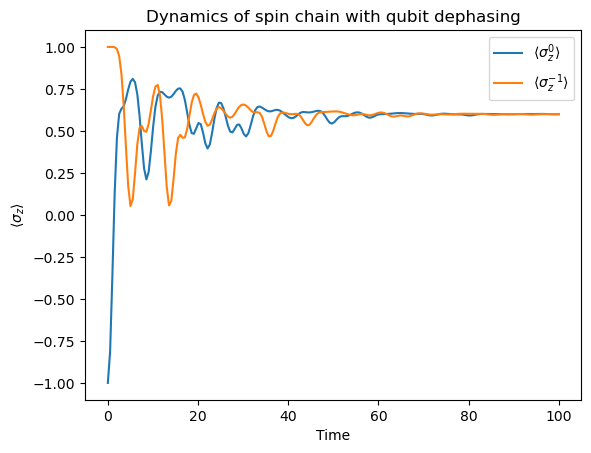

In [6]:
# dephasing rate
gamma = 0.02 * np.ones(N)

# collapse operators
c_ops = [np.sqrt(gamma[i]) * sz_list[i] for i in range(N)]

# evolution
result = result = mesolve(H, psi0, times, c_ops, [])

# Expectation value
exp_sz_dephase = expect(sz_list, result.states)

# Plot the expecation value
plt.plot(times, exp_sz_dephase[0], label=r"$\langle \sigma_z^{0} \rangle$")
plt.plot(times, exp_sz_dephase[-1], label=r"$\langle \sigma_z^{-1} \rangle$")
plt.legend()
plt.xlabel("Time"), plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Dynamics of spin chain with qubit dephasing");

### About

In [7]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.0.dev0+c874c4a
Numpy Version:      1.22.4
Scipy Version:      1.13.1
Cython Version:     3.0.10
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bi

### Testing

In [8]:
assert np.allclose(np.array(exp_sz_dephase)[:, -1], 0.6, atol=0.01)